In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob

import pandas as pd
import numpy as np

from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

## 01 데이터 병합 및 전처리

### 연령 기준 설정

In [2]:
# 해당연도 출생아
birth_age = ['0세']

# 유소년 인구 기준 : 14세 이하
yount_max_age = 14
youth_people_age = ['{}세'.format(age) for age in range(0, yount_max_age + 1)]

# 가임 여성 인구 수 : 20세 ~ 39세
max_young_women_age = 44
young_women_age = ['{}세'.format(age) for age in range(20, max_young_women_age + 1)]

# 고령인구 수 : 65세 이상
old_min_age = 70
old_people_age = ['{}세'.format(age) for age in range(old_min_age, 100)]
old_people_age.append('100세 이상')

### 인구데이터 병합

In [3]:
def data_merge(file_name):
    data_files = glob.glob(f'./Data/01 RAW/행정구역_{file_name}*.xlsx')
    data_files.sort()

    df = pd.DataFrame()

    for i, file in enumerate(data_files):
        tmp_df = pd.read_excel(file)
        tmp_df['행정구역(시도)'].fillna(method= 'ffill', inplace= True)

        if i == 0:
            df = pd.concat([df, tmp_df], axis= 1)

        else:
            df = df.merge(tmp_df, how= 'outer', on=['행정구역(시도)', '행정구역(시군구)별', '연령별'])

    df.dropna(inplace= True)            # 추후에 수정 해야함, 광역시의 경우 앞에 광역시명 붙이기

    columns = list(df.columns)
    year_columns = dict()
    for year in columns[3:]:
        year_columns[year] = np.int64

    df = df.astype(year_columns)

    df.to_csv('./Data/01 RAW/행정구역_{}_전체.csv'.format(file_name), index= False, encoding= 'utf-8-sig')
    return df

In [4]:
# 총인구
total_df = data_merge('총인구')
print(total_df.columns)

# 남자
men_df = data_merge('남자')
print(men_df.columns)

# 여자
women_df = data_merge('여자')
print(women_df.columns)

Index(['행정구역(시도)', '행정구역(시군구)별', '연령별', '2011 년', '2012 년', '2013 년', '2014 년',
       '2015 년', '2016 년', '2017 년', '2018 년', '2019 년', '2020 년', '2021 년',
       '2022 년'],
      dtype='object')
Index(['행정구역(시도)', '행정구역(시군구)별', '연령별', '2011 년', '2012 년', '2013 년', '2014 년',
       '2015 년', '2016 년', '2017 년', '2018 년', '2019 년', '2020 년', '2021 년',
       '2022 년'],
      dtype='object')
Index(['행정구역(시도)', '행정구역(시군구)별', '연령별', '2011 년', '2012 년', '2013 년', '2014 년',
       '2015 년', '2016 년', '2017 년', '2018 년', '2019 년', '2020 년', '2021 년',
       '2022 년'],
      dtype='object')


### 각 기준 별 인구 데이터 추출

In [5]:
def population_guideline(dataframe, guide_age):
    tmp_df = dataframe[dataframe['연령별'].isin(guide_age)]
    tmp_df = tmp_df.groupby(['행정구역(시도)', '행정구역(시군구)별']).sum()
    tmp_df.drop(['연령별'], axis= 1, inplace= True)
    tmp_df.reset_index(inplace= True, drop= False)

    return tmp_df

In [6]:
def population_rate(numerator, denominator, guid_col= ['행정구역(시도)', '행정구역(시군구)별']):
    numerator = numerator.set_index(guid_col)
    denominator = denominator.set_index(guid_col)
    
    rate_df = numerator.div(denominator, axis= 'columns', level= guid_col)
    rate_df.reset_index(inplace= True, drop= False)

    return rate_df

### (0) 각 지역 별 전체 인구수

In [7]:
total_df_sum = total_df.groupby(['행정구역(시도)', '행정구역(시군구)별']).sum()
total_df_sum.drop(['연령별'], axis= 1, inplace= True)
total_df_sum.reset_index(inplace= True, drop= False)
total_df_sum.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,217571,217741,216806,215807,214560,213846,213952,212957,213442,213321,212965,211381
1,강원특별자치도,고성군,30057,30124,30398,30269,30060,30114,30029,28144,27260,26757,27249,27274
2,강원특별자치도,동해시,95804,93897,95143,94562,93895,93297,92851,91272,90522,90593,90081,89426
3,강원특별자치도,삼척시,72312,72463,73023,72314,70839,69599,68514,68326,67228,65243,63429,63455
4,강원특별자치도,속초시,83745,83579,83109,82432,81992,81793,82273,81682,81786,82665,82791,82806


### (1) 가임여성 인구수

In [8]:
young_women_df = population_guideline(women_df, young_women_age)
young_women_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,35465,34786,33826,33021,32124,31232,30788,29864,29450,28938,28324,27535
1,강원특별자치도,고성군,3677,3643,3578,3464,3353,3286,3233,2858,2689,2576,2600,2600
2,강원특별자치도,동해시,15659,14915,14928,14302,13788,13352,12968,12185,11710,11418,11091,10724
3,강원특별자치도,삼척시,10429,10339,10251,9954,9595,9218,8941,8785,8346,7683,7173,7067
4,강원특별자치도,속초시,14054,13728,13176,12723,12261,11903,11807,11358,11073,11006,10941,10835


In [9]:
young_women_rate_df = population_rate(young_women_df, total_df_sum)
young_women_rate_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,0.163004,0.159759,0.156020,0.153012,0.149720,0.146049,0.143901,0.140235,0.137977,0.135655,0.132998,0.130262
1,강원특별자치도,고성군,0.122334,0.120933,0.117705,0.114441,0.111544,0.109119,0.107663,0.101549,0.098643,0.096274,0.095416,0.095329
2,강원특별자치도,동해시,0.163448,0.158844,0.156901,0.151245,0.146845,0.143113,0.139665,0.133502,0.129361,0.126036,0.123123,0.119920
3,강원특별자치도,삼척시,0.144222,0.142680,0.140380,0.137650,0.135448,0.132444,0.130499,0.128575,0.124145,0.117760,0.113087,0.111370
4,강원특별자치도,속초시,0.167819,0.164252,0.158539,0.154345,0.149539,0.145526,0.143510,0.139051,0.135390,0.133140,0.132152,0.130848


### (2) 고령인구

In [10]:
old_people_df = population_guideline(total_df, old_people_age)
old_people_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,21648,23115,24077,25224,26134,27022,28291,29361,30297,31252,31700,33232
1,강원특별자치도,고성군,4374,4656,4849,5026,5186,5390,5498,5564,5658,5698,5725,5869
2,강원특별자치도,동해시,8568,9100,9545,10015,10353,10629,11114,11623,12006,12387,12598,13194
3,강원특별자치도,삼척시,9115,9583,10007,10313,10511,10661,10920,11245,11545,11796,11696,12090
4,강원특별자치도,속초시,7338,7857,8204,8504,8783,9140,9609,9916,10301,10655,10785,11210


In [11]:
old_people_rate_df = population_rate(old_people_df, total_df_sum)
old_people_rate_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,0.099499,0.106158,0.111053,0.116882,0.121803,0.126362,0.132231,0.137873,0.141945,0.146502,0.148851,0.157214
1,강원특별자치도,고성군,0.145524,0.154561,0.159517,0.166044,0.172522,0.178987,0.183090,0.197698,0.207557,0.212954,0.210099,0.215187
2,강원특별자치도,동해시,0.089433,0.096915,0.100323,0.105909,0.110261,0.113926,0.119697,0.127345,0.132631,0.136732,0.139852,0.147541
3,강원특별자치도,삼척시,0.126051,0.132247,0.137039,0.142614,0.148379,0.153177,0.159383,0.164579,0.171729,0.180801,0.184395,0.190529
4,강원특별자치도,속초시,0.087623,0.094007,0.098714,0.103164,0.107120,0.111746,0.116794,0.121398,0.125951,0.128894,0.130268,0.135377


### (3) 유소년인구

In [12]:
youth_people_df = population_guideline(total_df, youth_people_age)
youth_people_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,31887,30689,29103,27700,26245,25274,24420,23539,22870,22290,21690,20772
1,강원특별자치도,고성군,3193,3073,2848,2715,2591,2487,2415,2148,2101,1987,2090,2070
2,강원특별자치도,동해시,14976,14090,14084,13534,12950,12483,12090,11577,11059,10810,10469,10030
3,강원특별자치도,삼척시,8827,8515,8102,7862,7514,7214,6844,6727,6509,6195,5825,5673
4,강원특별자치도,속초시,12938,12390,11767,11304,10713,10264,9838,9585,9309,9336,9147,8936


In [13]:
youth_people_rate_df = population_rate(youth_people_df, total_df_sum)
youth_people_rate_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,0.146559,0.140943,0.134235,0.128355,0.122320,0.118188,0.114138,0.110534,0.107149,0.104490,0.101848,0.098268
1,강원특별자치도,고성군,0.106231,0.102012,0.093690,0.089696,0.086194,0.082586,0.080422,0.076322,0.077073,0.074261,0.076700,0.075896
2,강원특별자치도,동해시,0.156319,0.150058,0.148030,0.143123,0.137920,0.133799,0.130209,0.126841,0.122169,0.119325,0.116218,0.112160
3,강원특별자치도,삼척시,0.122068,0.117508,0.110951,0.108720,0.106072,0.103651,0.099892,0.098454,0.096820,0.094953,0.091835,0.089402
4,강원특별자치도,속초시,0.154493,0.148243,0.141585,0.137131,0.130659,0.125488,0.119578,0.117345,0.113821,0.112938,0.110483,0.107915


### (4) 출생아수

In [14]:
birth_people_df = population_guideline(total_df, birth_age)
birth_people_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,1615,1582,1401,1254,1358,1204,1073,1020,970,936,874,890
1,강원특별자치도,고성군,200,187,152,151,143,152,128,100,128,94,92,109
2,강원특별자치도,동해시,751,745,732,691,650,644,571,465,417,399,421,379
3,강원특별자치도,삼척시,456,507,433,417,413,363,318,341,358,343,269,290
4,강원특별자치도,속초시,646,628,588,603,639,510,398,416,409,414,370,375


In [15]:
birth_people_rate_df = population_rate(birth_people_df, total_df_sum)
birth_people_rate_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,0.007423,0.007266,0.006462,0.005811,0.006329,0.005630,0.005015,0.004790,0.004545,0.004388,0.004104,0.004210
1,강원특별자치도,고성군,0.006654,0.006208,0.005000,0.004989,0.004757,0.005047,0.004263,0.003553,0.004696,0.003513,0.003376,0.003996
2,강원특별자치도,동해시,0.007839,0.007934,0.007694,0.007307,0.006923,0.006903,0.006150,0.005095,0.004607,0.004404,0.004674,0.004238
3,강원특별자치도,삼척시,0.006306,0.006997,0.005930,0.005767,0.005830,0.005216,0.004641,0.004991,0.005325,0.005257,0.004241,0.004570
4,강원특별자치도,속초시,0.007714,0.007514,0.007075,0.007315,0.007793,0.006235,0.004838,0.005093,0.005001,0.005008,0.004469,0.004529


### (5) 청년층 여성인구 비율

In [16]:
# 청년층 전체 인구 수
young_total_df = population_guideline(total_df, young_women_age)

men_women_rate_df = population_rate(young_women_df, young_total_df)
men_women_rate_df.head()

,행정구역(시도),행정구역(시군구)별,2011 년,2012 년,2013 년,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년
0,강원특별자치도,강릉시,0.477052,0.476155,0.475599,0.473997,0.473352,0.472682,0.472745,0.472457,0.472569,0.471211,0.469632,0.468242
1,강원특별자치도,고성군,0.398720,0.388587,0.369972,0.369060,0.371195,0.377441,0.380980,0.387210,0.400268,0.405286,0.407013,0.409901
2,강원특별자치도,동해시,0.472126,0.469867,0.468609,0.463478,0.461569,0.461289,0.457893,0.456077,0.456352,0.452485,0.450670,0.449908
3,강원특별자치도,삼척시,0.437513,0.436300,0.429721,0.435471,0.443105,0.446479,0.451087,0.452089,0.453760,0.453167,0.455776,0.453565
4,강원특별자치도,속초시,0.490045,0.489011,0.484483,0.484151,0.479620,0.476768,0.473929,0.471345,0.465977,0.461371,0.459012,0.458741


## 02 시계열 클러스터분석

In [17]:
def mk_timeseries(dataframe, drop_columns= ['행정구역(시도)', '행정구역(시군구)별']):
    return dataframe[dataframe.columns.drop(drop_columns)].values.tolist(), dataframe[dataframe.columns.drop(drop_columns)].columns.tolist()

In [18]:
index_values = old_people_df[['행정구역(시도)', '행정구역(시군구)별']].values.tolist()

# 5가지 지표 시계열 데이터
young_women_timeseries, columns = mk_timeseries(young_women_df)
old_people_timeseries, _ = mk_timeseries(old_people_df)
youth_people_timeseries, _ = mk_timeseries(youth_people_df)
birth_people_timeseries, _ = mk_timeseries(birth_people_df)

# young_women_timeseries, columns = mk_timeseries(young_women_rate_df)
# old_people_timeseries, _ = mk_timeseries(old_people_rate_df)
# youth_people_timeseries, _ = mk_timeseries(youth_people_rate_df)
# birth_people_timeseries, _ = mk_timeseries(birth_people_rate_df)
# women_rate_timeseries, _ = mk_timeseries(men_women_rate_df)

time_series_data = list()
# for young_women, old, youth, birth, women_rate in zip(young_women_timeseries, old_people_timeseries, youth_people_timeseries, birth_people_timeseries, women_rate_timeseries):
for young_women, old, youth, birth in zip(young_women_timeseries, old_people_timeseries, youth_people_timeseries, birth_people_timeseries):
    # time_series_data.append([young_women, old, youth, birth, women_rate])
    time_series_data.append([young_women, old, youth, birth])

In [19]:
def find_best_cluster_num(time_series_data, max_num = 10):
    pred_list, inertia_list, center_list = list(), list(), list()

    for k in range(1, max_num + 1):
        km = TimeSeriesKMeans(n_clusters= k, verbose=False, random_state=42, n_jobs= -1, max_iter= 100, metric= 'softdtw')
        # metric = {"euclidean", "dtw", "softdtw"} (기본값: "euclidean")
        
        y_pred = km.fit_predict(time_series_data)
        pred_list.append(y_pred)

        inertia = km.inertia_
        inertia_list.append(inertia)

        cluster_center = km.cluster_centers_
        center_list.append(cluster_center)

    return pred_list, inertia_list, center_list

In [20]:
max_cluster_num = 20
pred_list, inertia_list, center_list = find_best_cluster_num(time_series_data, max_cluster_num)

### 최적의 K 찾기

In [21]:
SAVE_PATH = '/Users/woo/Dropbox/2023 도시데이터혁신연구실/02. 프로젝트/06. [한반도미래인구연구원] 인구구조 기반 도시 유형화 및 유형별 인구영향평가 지표·지수 수립/03. 자료조사/05. 클러스터분석/# Cluster Visualization/'

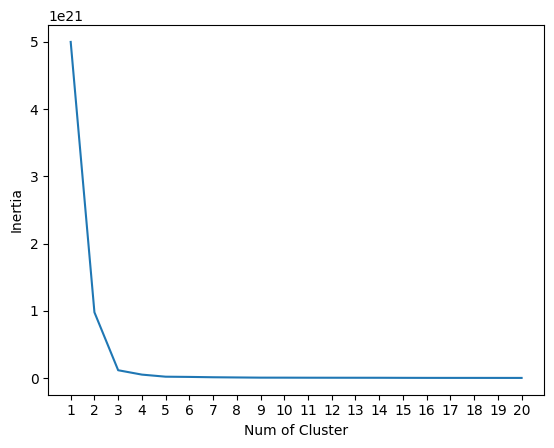

In [22]:
# inertia vis
X_range = [x for x in range(1, max_cluster_num + 1)]
plt.plot(X_range, inertia_list)
plt.xticks(X_range)
plt.ylabel("Inertia")
plt.xlabel("Num of Cluster")
plt.savefig(SAVE_PATH + 'inertia.png')
plt.show()

In [27]:
best_K = 3

# 시군구 Cluster 분류
y_pred = pred_list[best_K - 1]
index_sido = [x[0] for x in index_values]
index_sigungu = [x[1] for x in index_values]

result_list = [[sido, sigun, num] for sido, sigun, num in zip(index_sido, index_sigungu, y_pred)]
result_df = pd.DataFrame(result_list, columns= ['행정구역(시도)', '행정구역(시군구)별', 'cluster_n'])
result_df.to_excel(SAVE_PATH + 'Cluster Predict.xlsx', index= False)
# result_df.head()

In [28]:
count_ = pd.DataFrame(result_df['cluster_n'].value_counts().sort_index())
count_.reset_index(inplace= True, drop= False)
count_.to_excel(SAVE_PATH + 'Number of Urban in Each Cluster.xlsx', index= False)

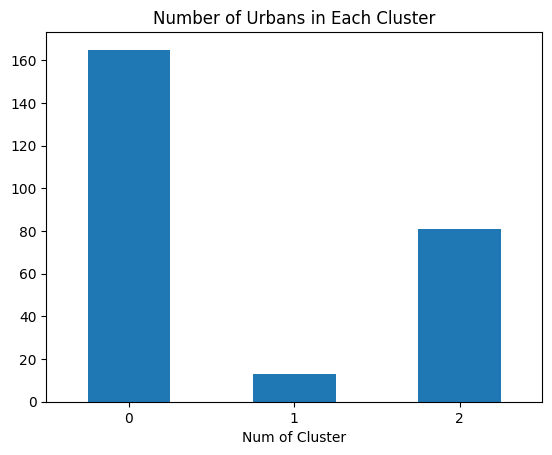

In [29]:
result_df['cluster_n'].value_counts().sort_index().plot(kind= 'bar')
plt.title('Number of Urbans in Each Cluster')
plt.xlabel('Num of Cluster')
plt.xticks(rotation=0)
plt.savefig(SAVE_PATH + 'Number of Urbans in Each Cluster Vis.png')
plt.show()

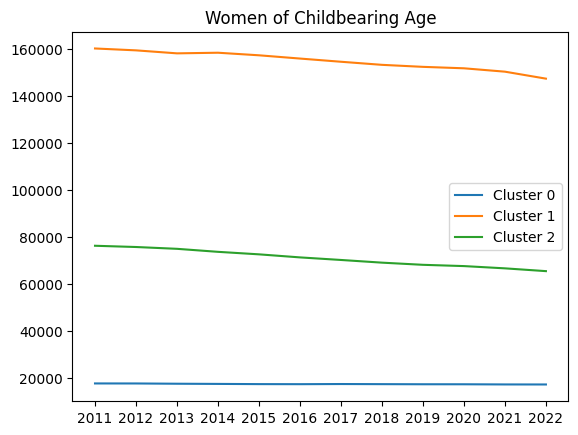

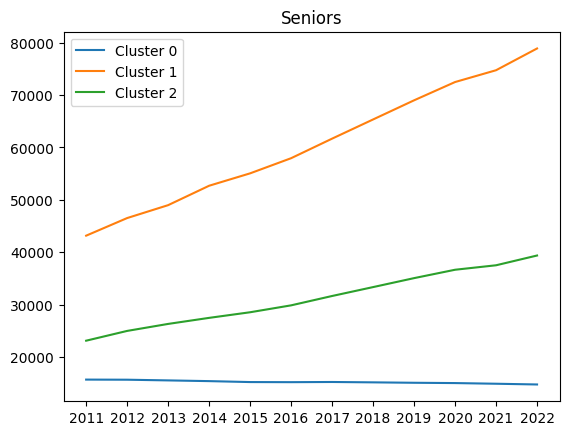

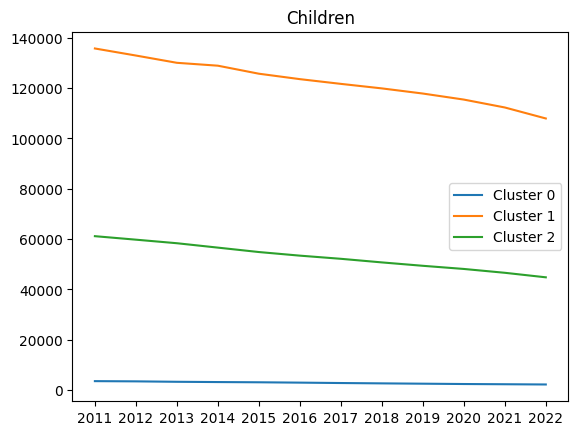

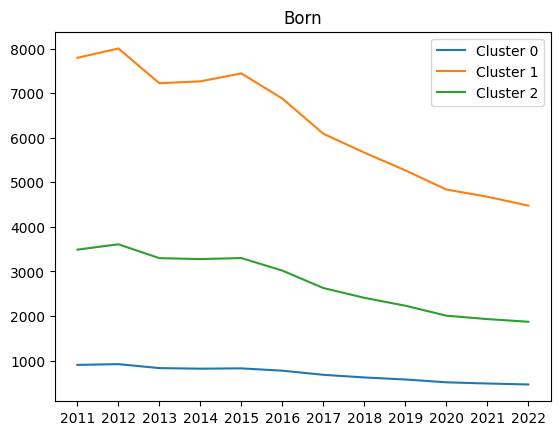

In [30]:
center_cluster = center_list[best_K - 1]
years = [x.replace(' 년', '') for x in columns]
# values = ['Women of Childbearing Age', 'Seniors', 'Children', 'Born', 'The Ratio of Young Men and Women']
values = ['Women of Childbearing Age', 'Seniors', 'Children', 'Born']

for val in values:
    plt.Figure()
    for k in range(0, best_K):
        plt.plot(years, center_cluster[k][values.index(val)])
        plt.title(val)
    plt.legend(['Cluster {}'.format(k) for k in range(0, best_K)])
    plt.savefig(SAVE_PATH + '[{}] characteristic of each cluster.png'.format(val))
    plt.show()